# An introduction to `relatio` 
**Runtime $\sim$ 20min**

----------------------------

This is a short demo of the package `relatio`.  It takes as input a text corpus and outputs a list of narrative statements. The pipeline is unsupervised: the user does not need to specify narratives beforehand. Narrative statements are defined as tuples of semantic roles with a (agent, verb, patient, attribute) structure. 

Here, we present the main wrapper functions to quickly obtain narrative statements from a corpus.

For further details, please refer to the paper: ["Text Semantics Capture Political and Economic Narratives"](https://arxiv.org/abs/2108.01720)

----------------------------

We provide datasets that have already been split into sentences and annotated by our team.

The datasets are provided in three different formats:
 1. `raw` (unprocessed)
 2. `split_sentences` (as a list of sentences)
 3. `srl` (as a list of annotated sentences by the semantic role labeler)

In this tutorial, we work with the Trump Tweet Archive corpus.

----------------------------

In [1]:
# Get list of available datasets

from relatio.datasets import list_datasets

print(list_datasets())

# Download Trump Tweet Archive in "raw" format

from relatio.datasets import load_trump_data

df = load_trump_data("raw")

print(df.head())



    List of available datasets:

    Trump Tweet Archive
    - function call: load_trump_data()
    - format: 'raw', 'split_sentences', 'srl_res'
    - allennlp version: 0.9
    - srl model: srl-model-2018.05.25.tar.gz
    
             id                                                doc
0  9.845497e+16  Republicans and Democrats have both created ou...
1  1.234653e+18  I was thrilled to be back in the Great city of...
2  1.304875e+18  The Unsolicited Mail In Ballot Scam is a major...
3  1.223641e+18            Getting a little exercise this morning!
4  1.215248e+18                                   Thank you Elise!


## Step 1: Split into sentences

----------------------------

For any new corpus, the first thing you will want to do is to split the corpus into sentences.

We do this on the first 100 tweets. 

The output is two lists: one with an index for the document and one with the resulting split sentences.

----------------------------


In [2]:
from relatio.utils import split_into_sentences

split_sentences = split_into_sentences(
    df.iloc[0:100], progress_bar=True
)

for i in range(5):
    print('Document id: %s' %split_sentences[0][i])
    print('Sentence: %s \n' %split_sentences[1][i])

Splitting into sentences...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 346.16it/s]

Document id: 9.84549706549166e+16
Sentence: Republicans and Democrats have both created our economic problems. 

Document id: 1.23465342778907e+18
Sentence: I was thrilled to be back in the Great city of Charlotte, North Carolina with thousands of hardworking American Patriots who love our Country, cherish our values, respect our laws, and always put AMERICA FIRST! 

Document id: 1.23465342778907e+18
Sentence: Thank you for a wonderful evening!! 

Document id: 1.30487517086002e+18
Sentence: The Unsolicited Mail In Ballot Scam is a major threat to our Democracy, &amp; the Democrats know it. 

Document id: 1.30487517086002e+18
Sentence: Almost all recent elections using this system, even though much smaller &amp; with far fewer Ballots to count, have ended up being a disaster. 



## Step 2: Annotate semantic roles

----------------------------

Once the corpus is split into sentences. You can feed it to the semantic role labeler.

The output is a list of json objects which contain the semantic role annotations for each sentence in the corpus.

----------------------------


In [3]:
# Note that SRL is time-consuming, in particular on CPUs.
# To speed up the annotation, you can also use GPUs via the "cuda_device" argument of the "run_srl()" function. 

from relatio.wrappers import run_srl

srl_res = run_srl(
    path="https://storage.googleapis.com/allennlp-public-models/openie-model.2020.03.26.tar.gz", # pre-trained model
    sentences=split_sentences[1],
    progress_bar=True,
)

/home/germain/Desktop/narratives/relatio/venv/lib/python3.8/site-packages/allennlp/tango/__init__.py:17: UserWarning: AllenNLP Tango is an experimental API and parts of it might change or disappear every time we release a new version.
  warnings.warn(
2021-09-20 13:52:47,222 - INFO - allennlp.common.plugins - Plugin allennlp_models available
2021-09-20 13:52:47,503 - INFO - allennlp.common.file_utils - cache of https://storage.googleapis.com/allennlp-public-models/openie-model.2020.03.26.tar.gz is up-to-date
2021-09-20 13:52:47,505 - INFO - allennlp.models.archival - loading archive file https://storage.googleapis.com/allennlp-public-models/openie-model.2020.03.26.tar.gz from cache at /home/germain/.allennlp/cache/60314a853eb0aaa774d176d878c62469d49872feb4f2bfd071a75c77f6d76707.1b91cc27e347f2df04ce771a304bee2b70a2c487626b67e277d44c593b868c25
2021-09-20 13:52:47,507 - INFO - allennlp.models.archival - extracting archive file /home/germain/.allennlp/cache/60314a853eb0aaa774d176d878c62469

Running SRL...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.91s/it]


In [4]:
# An example of SRL output

srl_res[0]

{'verbs': [{'verb': 'have',
   'description': 'Republicans and Democrats [V: have] both created our economic problems .',
   'tags': ['O', 'O', 'O', 'B-V', 'O', 'O', 'O', 'O', 'O', 'O']},
  {'verb': 'created',
   'description': '[ARG0: Republicans and Democrats] have both [V: created] [ARG1: our economic problems] .',
   'tags': ['B-ARG0',
    'I-ARG0',
    'I-ARG0',
    'O',
    'O',
    'B-V',
    'B-ARG1',
    'I-ARG1',
    'I-ARG1',
    'O']}],
 'words': ['Republicans',
  'and',
  'Democrats',
  'have',
  'both',
  'created',
  'our',
  'economic',
  'problems',
  '.']}

In [5]:
# To save us some time, we download the results from the datasets module.

split_sentences = load_trump_data("split_sentences")
srl_res = load_trump_data("srl_res")

## Step 3: Build the narrative model

----------------------------

We are now ready to build a narrative model.

The function `build_narrative_model` takes as input the split sentences the SRL annotations for the corpus. It builds a model of low-dimensional narrative statements which may then be used to obtain narrative statements  "out-of-sample".

The function has sensible defaults for most arguments, but the user should at least specify:
- the number of latent unnamed entities to recover (`n_clusters`)
- the embeddings to be used (see here for further details) 

We specify 100 unnamed entities to uncover. The embeddings used are pre-trained glove embeddings.

To speed up the model's training, we also focus on the top 100 most frequent named entities (the default is to mine all named entities).

To improve interpretability, we remove common uninformative words in the corpus (the "stopwords"), as well as one-letter words.

----------------------------

In [6]:
# Get list of stopwords from SpaCy

import spacy
spacy_stopwords = spacy.lang.en.stop_words.STOP_WORDS

# NB: This step usually takes several minutes to run. You might want to grab a coffee.
 
from relatio.wrappers import build_narrative_model

narrative_model = build_narrative_model(
    srl_res=srl_res,
    sentences=split_sentences[1],
    embeddings_type="gensim_keyed_vectors",  # see documentation for a list of supported types
    embeddings_path="glove-wiki-gigaword-300",
    n_clusters=[[100]],
    top_n_entities=100,
    stop_words = spacy_stopwords,
    remove_n_letter_words = 1,
    progress_bar=True,
)

Processing SRL...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 68616/68616 [00:01<00:00, 39976.78it/s]


Cleaning SRL...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150213/150213 [01:07<00:00, 2223.05it/s]


Computing role frequencies...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150213/150213 [00:00<00:00, 985053.11it/s]


Mining named entities...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 68616/68616 [05:40<00:00, 201.56it/s]


Mapping named entities...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150213/150213 [00:11<00:00, 13596.38it/s]
2021-09-20 14:02:25,795 - INFO - gensim.models.utils_any2vec - loading projection weights from /home/germain/gensim-data/glove-wiki-gigaword-300/glove-wiki-gigaword-300.gz


Loading embeddings model...


2021-09-20 14:04:09,799 - INFO - gensim.models.utils_any2vec - loaded (400000, 300) matrix from /home/germain/gensim-data/glove-wiki-gigaword-300/glove-wiki-gigaword-300.gz
/home/germain/Desktop/narratives/relatio/relatio/clustering.py:327: RuntimeWarning: Multiple labels for cluster 63- 2 shown: [('community', 29), ('fair', 29)]. First one is picked.
  warnings.warn(
/home/germain/Desktop/narratives/relatio/relatio/clustering.py:327: RuntimeWarning: Multiple labels for cluster 4- 2 shown: [('system', 58), ('information', 58)]. First one is picked.
  warnings.warn(
/home/germain/Desktop/narratives/relatio/relatio/clustering.py:327: RuntimeWarning: Multiple labels for cluster 53- 2 shown: [('tenacious', 15), ('stubborn', 15)]. First one is picked.
  warnings.warn(
/home/germain/Desktop/narratives/relatio/relatio/clustering.py:327: RuntimeWarning: Multiple labels for cluster 62- 2 shown: [('medicare', 14), ('fema', 14)]. First one is picked.
  warnings.warn(
2021-09-20 14:07:28,636 - INF

In [7]:
# The narrative model is simply a dictionary containing the narrative model's specifics.

print(narrative_model.keys())

dict_keys(['roles_considered', 'roles_with_entities', 'roles_with_embeddings', 'dimension_reduce_verbs', 'clean_text_options', 'verb_counts', 'entities', 'top_n_entities', 'embeddings_model', 'cluster_model', 'cluster_labels_most_similar', 'cluster_labels_most_freq'])


In [8]:
# Most common named entities

narrative_model['entities'].most_common()[:20]

[('democrat', 1476),
 ('china', 929),
 ('obama', 867),
 ('american', 839),
 ('republican', 837),
 ('america', 558),
 ('barackobama', 545),
 ('united state', 476),
 ('trump', 419),
 ('dems', 415),
 ('congress', 389),
 ('russia', 386),
 ('donald trump', 341),
 ('iran', 328),
 ('florida', 319),
 ('cnn', 318),
 ('usa', 314),
 ('hillary', 308),
 ('senate', 301),
 ('hillary clinton', 287)]

In [9]:
# The unnamed entities uncovered in the corpus 
# (automatically labeled by the most frequent phrase in the cluster)

narrative_model['cluster_labels_most_freq']

[[{54: 'economy',
   76: 'people',
   97: 'stock market',
   46: 'government',
   84: 'fantastic',
   86: 'email',
   63: 'community',
   70: 'day',
   4: 'system',
   90: 'vote',
   95: 'disaster',
   45: 'clue',
   83: 'job',
   0: 'kurd',
   80: 'protester',
   37: 'terrible',
   47: 'thing',
   65: 'flag',
   21: 'fight',
   82: 'election',
   74: 'second amendment',
   22: 'omarosa',
   33: 'unemployment',
   5: 'success',
   15: 'amaze',
   92: 'press',
   3: 'global warm',
   29: 'politician',
   28: 'deal',
   98: 'win',
   77: 'bankrupt',
   94: 'james comey',
   42: 'ill',
   87: 'courage',
   50: 'life',
   81: 'politically correct',
   2: 'fraud',
   12: 'president',
   10: 'pocahontas',
   7: 'hell',
   31: 'twitter',
   11: 'question',
   25: 'man',
   59: 'business',
   35: 'city',
   85: 'baltimore',
   58: 'collusion',
   36: 'terrorist',
   8: 'case',
   9: 'safe',
   60: 'fine',
   26: 'tv',
   32: 'problem',
   27: 'john bolton',
   23: 'military',
   43: 'crime',
 

----------------------------

In practice, `build_narrative_model` is a flexible wrapper function which gives a lot of control to the user. 

Let's break the options down into four categories:

1. Basic utilities
    - the semantic roles you're interested in (`roles_considered`)
    - where you would like to save the model (`output_path`)
    - whether you cant to track the function's progress (`progress_bar`)
    

2. Text preprocessing
    - basic text preprocessing steps 
    (`remove_punctuation`, `remove_digits`, remove `stop_words`, `stem` or `lemmatize` words, etc.)
    - would you like to replace verbs by their most common synonyms/antonyms? (`dimension_reduce_verbs`)


3. Named entities  
    - which semantic roles have named entities? (`roles_with_entities`)
    - how many named entities would you like to keep? (`top_n_entities`)

Technical details: under the hood, we work with SpaCy named entity recognizer to identify named entities. 
We consider tags related to places, organizations, people and events.


4. Unnamed entities (e.g., tax, government, dog, cat, etc.)
    - which semantic roles have unnamed entities? (`roles_with_embeddings`)
    - how many latent unnamed entities are there in the corpus? (`n_clusters`)

Technical details: under the hood, we embed semantic phrases without named entities and cluster them with 
K-Means. 

----------------------------

## Step 4: Get narrative statements based on the narrative model.

----------------------------

Once the narrative model is built, we can use it to extract narrative statements from any corpus (provided that the 
corpus is split into sentences and annotated for semantic roles). 

We call the function `get_narratives` for this purpose.

----------------------------

In [10]:
from relatio.wrappers import get_narratives

final_statements = get_narratives(
    srl_res=srl_res,
    doc_index=split_sentences[0],  # doc names
    narrative_model=narrative_model,
    n_clusters=[0],  
    progress_bar=True,
)

Processing SRL...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 68616/68616 [00:01<00:00, 39042.84it/s]


Cleaning SRL...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150213/150213 [01:18<00:00, 1923.34it/s]


Processing raw arguments...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150213/150213 [00:00<00:00, 1054245.06it/s]


Cleaning verbs...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150213/150213 [00:02<00:00, 66995.87it/s]


Mapping named entities...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150213/150213 [00:11<00:00, 13232.48it/s]


Assigning clusters to roles...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150213/150213 [00:29<00:00, 5153.31it/s]


In [11]:
# The resulting pandas dataframe

print(final_statements.columns)

final_statements.head()

Index(['doc', 'sentence', 'statement', 'ARG0_highdim', 'ARG0_lowdim',
       'B-V_highdim', 'B-V_lowdim', 'B-ARGM-NEG_highdim', 'B-ARGM-NEG_lowdim',
       'B-ARGM-MOD_highdim', 'ARG1_highdim', 'ARG1_lowdim', 'ARG2_highdim',
       'ARG2_lowdim'],
      dtype='object')


,doc,sentence,statement,ARG0_highdim,ARG0_lowdim,B-V_highdim,B-V_lowdim,B-ARGM-NEG_highdim,B-ARGM-NEG_lowdim,B-ARGM-MOD_highdim,ARG1_highdim,ARG1_lowdim,ARG2_highdim,ARG2_lowdim
0,98454970654916608,0,0,,,,,,,,,,,
1,98454970654916608,0,1,republican democrat,republican,create,create,,,,economic problem,economy,,
2,1234653427789070336,1,2,,,,,,,,,,thrill great city charlotte north carolina tho...,north carolina
3,1234653427789070336,1,3,,,thrill,thrill,,,,,,great city charlotte north carolina thousand h...,north carolina
4,1234653427789070336,1,4,,,,,,,,,,great city charlotte north carolina,north carolina


### Trying out different clustering scenarios

The choice of the number of clusters is corpus and application specific. Specifying a small number of latent entities leads to a large dimension reduction and may decrease entity coherence, whilst specifying a large number of latent entities may produce cluster redundancy. 

To help users try different clustering scenarios, the wrapper functions `build_narrative_model` and `get_narratives` allow users to experiment various clustering scenarios, which we detail below.

----------------------------

In `build_narrative_model`, the arguments `roles_with_embeddings` and `n_clusters` are specified as lists of lists arguments. This implies that you can cluster semantic roles separately (or together) and with different numbers of clusters. 

For example, a user could specify:
- `roles_with_embeddings = [["ARG0"],["ARG1"]]`
- `n_clusters = [[10,20],[10]]`
    
He/she would then cluster "ARG0" and "ARG1" separately and not consider "ARG2" for dimension reduction. For "ARG0", the clustering scenarios are a model with 10 and a model with 20 clusters. For "ARG1", the clustering scenario is a model with 10 clusters.


----------------------------

To extract narrative statements based on a clustering scenario, the `get_narratives` function also has the 
`n_clusters` argument. 

`n_clusters` is a list for the clustering scenarios. For instance, in our previous example, 
semantic roles "ARG0" and "ARG1" are clustered separately, so `n_clusters` expects two indices: one for the 
clustering scenario to pick for "ARG0" and one for the clustering scenario to pick for "ARG1".

For example, a user could specify:
- `n_clusters = [0,0]`

He/she would then extract narrative statements based on 10 clusters for "ARG0" and 10 clusters for "ARG1".

----------------------------

## Step 5: Model validation and basic analysis

----------------------------

The resulting `final_statments` object is a pandas dataframe which lists narrative statements found in documents and 
sentences of the corpus.

It is straight-forward to manually inspect the quality of the resulting entities and narrative statements.

----------------------------

In [12]:
# Entity coherence
# Print most frequent phrases per entity

# Pool ARG0, ARG1 and ARG2 together

df1 = final_statements[['ARG0_lowdim', 'ARG0_highdim']]
df1.rename(columns={'ARG0_lowdim': 'ARG', 'ARG0_highdim': 'ARG-RAW'}, inplace=True)

df2 = final_statements[['ARG1_lowdim', 'ARG1_highdim']]
df2.rename(columns={'ARG1_lowdim': 'ARG', 'ARG1_highdim': 'ARG-RAW'}, inplace=True)

df3 = final_statements[['ARG2_lowdim', 'ARG2_highdim']]
df3.rename(columns={'ARG2_lowdim': 'ARG', 'ARG2_highdim': 'ARG-RAW'}, inplace=True)

df = df1.append(df2).reset_index(drop = True)
df = df.append(df3).reset_index(drop = True)

# Count semantic phrases

df = df.groupby(['ARG', 'ARG-RAW']).size().reset_index()
df.columns = ['ARG', 'ARG-RAW', 'count']

# Drop empty semantic phrases

df = df[df['ARG'] != ''] 

# Rearrange the data

df = df.groupby(['ARG']).apply(lambda x: x.sort_values(["count"], ascending = False))
df = df.reset_index(drop= True)
df = df.groupby(['ARG']).head(10)

df['ARG-RAW'] = df['ARG-RAW'] + ' - ' + df['count'].astype(str)
df['cluster_elements'] = df.groupby(['ARG'])['ARG-RAW'].transform(lambda x: ' | '.join(x))

df = df.drop_duplicates(subset=['ARG'])

df['cluster_elements'] = [', '.join(set(i.split(','))) for i in list(df['cluster_elements'])]

print('Entities to inspect:', len(df))

df = df[['ARG', 'cluster_elements']]

/home/germain/Desktop/narratives/relatio/venv/lib/python3.8/site-packages/pandas/core/frame.py:5034: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


Entities to inspect: 196


In [13]:
for l in df.values.tolist():
    print('entity: \n %s \n' % l[0])
    print('most frequent phrases: \n %s \n' % l[1])

entity: 
 abc 

most frequent phrases: 
 abc - 16 | abc news - 4 | abc debate - 3 | people lose money stock market point base false dishonest reporting brian ross abc news suspend - 3 | abc washington post poll - 3 | fake news cnn msdnc abc nbc cbs fox desperately amp foolishly plead politically correct nytimes amp washingtonpost - 2 | big new abc poll - 2 | fake abc news - 2 | lonely brian ross abc news - 1 | lead big new abc poll week - 1 

entity: 
 administration 

most frequent phrases: 
 administration - 125 | obama administration - 59 | trump administration - 34 | previous administration - 8 | president administration - 5 | past administration - 4 | ig spent year obama administration report fail hn swine flu debacle people die - 3 | bloomberg administration - 3 | administration history country - 3 | trump administration anti trust division - 3 

entity: 
 alabama 

most frequent phrases: 
 alabama - 24 | great state alabama - 3 | people alabama - 3 | alabama receive hurt - 2 | m

In [14]:
# Low-dimensional vs. high-dimensional narrative statements

# Replace negated verbs by "not_verb"

import numpy as np

final_statements['B-V_lowdim_with_neg'] = np.where(final_statements['B-ARGM-NEG_lowdim'] == True, 
                                          final_statements['B-V_lowdim'],
                                          'not_' + final_statements['B-V_lowdim'])

final_statements['B-V_highdim_with_neg'] = np.where(final_statements['B-ARGM-NEG_highdim'] == True, 
                                           final_statements['B-V_highdim'],
                                           'not_' + final_statements['B-V_highdim'])

# Concatenate high-dimensional narratives (with text preprocssing but no clustering)

final_statements['narrative_highdim'] = (final_statements['ARG0_highdim'] + ' ' + 
                                         final_statements['B-V_highdim_with_neg'] + ' ' +  
                                         final_statements['ARG1_highdim'])

# Concatenate low-dimensional narratives (with clustering)

final_statements['narrative_lowdim'] = (final_statements['ARG0_lowdim'] + ' ' + 
                                        final_statements['B-V_highdim_with_neg'] + ' ' + 
                                        final_statements['ARG1_lowdim'])

# Focus on narratives with a ARG0-VERB-ARG1 structure (i.e. "complete narratives")

indexNames = final_statements[(final_statements['ARG0_lowdim'] == '')|
                             (final_statements['ARG1_lowdim'] == '')|
                             (final_statements['B-V_lowdim_with_neg'] == '')].index

complete_narratives = final_statements.drop(indexNames)

complete_narratives

,doc,sentence,statement,ARG0_highdim,ARG0_lowdim,B-V_highdim,B-V_lowdim,B-ARGM-NEG_highdim,B-ARGM-NEG_lowdim,B-ARGM-MOD_highdim,ARG1_highdim,ARG1_lowdim,ARG2_highdim,ARG2_lowdim,B-V_lowdim_with_neg,B-V_highdim_with_neg,narrative_highdim,narrative_lowdim
1,98454970654916608,0,1,republican democrat,republican,create,create,,,,economic problem,economy,,,create,create,republican democrat create economic problem,republican create economy
6,1234653427789070336,1,6,hardworking american patriot,american,love,know,,,,country,people,,,know,love,hardworking american patriot love country,american love people
7,1234653427789070336,1,7,hardworking american patriot,american,cherish,cherish,,,,value,stock market,,,cherish,cherish,hardworking american patriot cherish value,american cherish stock market
8,1234653427789070336,1,8,hardworking american patriot,american,respect,honor,,,,law,government,,,honor,respect,hardworking american patriot respect law,american respect government
13,1304875170860015617,4,13,recent election,day,use,use,,,,system,system,,,use,use,recent election use system,day use system
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
150179,1213149809378578432,68602,150179,motion,case,dismiss,fire,,,,impeachment trial,case,,,fire,dismiss,motion dismiss impeachment trial,case dismiss case
150193,1213078681750573056,68606,150193,iran,iran,won,lose,True,,,war,fight,,,lose,not-lose,iran not-lose war,iran not-lose fight
150194,1213078681750573056,68606,150194,iran,iran,lose,win,True,,,negotiation,deal,,,win,not-win,iran not-win negotiation,iran not-win deal
150209,1319384118849949702,68612,150209,obama biden,biden,fail,fail,,,,worker delphi,bankrupt,,,fail,fail,obama biden fail worker delphi,biden fail bankrupt


In [15]:
# Top high-dimensional complete narrative statements

complete_narratives['narrative_highdim'].value_counts().head(10)

god bless usa                                  13
think small negate lot                          9
establishment special interest kill country     8
thing look good                                 7
democrat want open border                       6
stock market hit time high                      6
success breed success                           6
china steal job                                 6
biden raise tax                                 6
successful require concentrate effort           5
Name: narrative_highdim, dtype: int64

In [16]:
# Top low-dimensional complete narrative statements

complete_narratives['narrative_lowdim'].value_counts().head(10)

stock market hit record         17
democrat want border            16
god bless usa                   13
thing look job                   9
people negate job                9
crooked hillary delete email     8
community kill people            8
biden raise tax                  6
success breed success            6
china steal job                  6
Name: narrative_lowdim, dtype: int64

In [17]:
# Print ten random complete narratives with and without dimension reduction
#
# Specifying a small number of clusters leads to a large dimension reduction 
# and may decrease cluster coherence, whilst specifying a large number of clusters
# may produce cluster redundancy. 
#
# The choice of the number of clusters is corpus and application specific 
# (and was chosen at random in this notebook).

sample = complete_narratives.sample(10, random_state = 123).to_dict('records')

for d in sample:
    print('Original raw tweet: \n %s \n' %split_sentences[1][d['sentence']])
    print('High-dimensional narrative: \n %s \n' %d['narrative_highdim'])
    print('Low-dimensional narrative: \n %s \n' %d['narrative_lowdim'])
    print('--------------------------------------------------- \n')

Original raw tweet: 
 After Solyndra, BarackObama is stil intent on wasting our tax dollars on unproven technologies and risky companies. 

High-dimensional narrative: 
 barackobama waste tax dollar unproven technology risky company 

Low-dimensional narrative: 
 barackobama waste politically correct 

--------------------------------------------------- 

Original raw tweet: 
 Both Senators became totally unelectable, couldnt come even close to winning their primaries, and decided to drop out of politics and gracefully RETIRE. 

High-dimensional narrative: 
 senator decide drop politics gracefully retire 

Low-dimensional narrative: 
 jeb decide ventilator 

--------------------------------------------------- 

Original raw tweet: 
 The Republicans never should have agreed to this past summer's debt deal. 

High-dimensional narrative: 
 republican not-disagree past summer debt deal 

Low-dimensional narrative: 
 republican not-disagree people 

-----------------------------------------

## Step 6: Visualization // Plotting narrative graphs
----------------------------

A collection of narrative statements has an intuitive network structure, in which the edges are verbs and the nodes are entities.

Here, we plot Trump's narrative statements on Twitter.

----------------------------

In [18]:
# Plot low-dimensional complete narrative statements in a directed multi-graph

from relatio.graphs import build_graph, draw_graph

temp = complete_narratives[["ARG0_lowdim", "ARG1_lowdim", "B-V_lowdim"]]
temp.columns = ["ARG0", "ARG1", "B-V"]
temp = temp[(temp["ARG0"] != "") & (temp["ARG1"] != "") & (temp["B-V"] != "")]
temp = temp.groupby(["ARG0", "ARG1", "B-V"]).size().reset_index(name="weight")
temp = temp.sort_values(by="weight", ascending=False).iloc[
    0:100
]  # pick top 100 most frequent narratives
temp = temp.to_dict(orient="records")

for l in temp:
    l["color"] = None

G = build_graph(
    dict_edges=temp, dict_args={}, edge_size=None, node_size=10, prune_network=True
)

draw_graph(G, notebook=True, output_filename="trump_worldview.html")

In [19]:
# As a final comment, note that you can look up the specifics of any function with the help command.

help(build_narrative_model)

Help on function build_narrative_model in module relatio.wrappers:

build_narrative_model(srl_res: List[dict], sentences: List[str], roles_considered: List[str] = ['ARG0', 'B-V', 'B-ARGM-NEG', 'B-ARGM-MOD', 'ARG1', 'ARG2'], output_path: Union[str, NoneType] = None, max_length: Union[int, NoneType] = None, remove_punctuation: bool = True, remove_digits: bool = True, remove_chars: str = '', stop_words: Union[List[str], NoneType] = None, lowercase: bool = True, strip: bool = True, remove_whitespaces: bool = True, lemmatize: bool = True, stem: bool = False, tags_to_keep: Union[List[str], NoneType] = None, remove_n_letter_words: Union[int, NoneType] = None, roles_with_embeddings: List[List[str]] = [['ARG0', 'ARG1', 'ARG2']], embeddings_type: Union[str, NoneType] = None, embeddings_path: Union[str, NoneType] = None, n_clusters: List[List[int]] = [[1]], verbose: int = 0, random_state: int = 0, roles_with_entities: List[str] = ['ARG0', 'ARG1', 'ARG2'], ent_labels: List[str] = ['PERSON', 'NORP'

## Step 7: Construction of a RDF graph
----------------------------

A collection of narrative statements has an intuitive network structure, in which the edges are verbs and the nodes are entities.

In this section, we build a RDF triplestore from Trump's narrative statements on Twitter.

----------------------------

In [1]:
import pandas as pd
path = '../../complete_narratives.csv'
complete_narratives = pd.read_csv(path)

In [2]:
from relatio.triplestore import build_triplestore

# Enrich triplestore
spacy = True
wikidata = False     # A bit slow
wordnet = True

# For speed matters, limit to 10 first triples
df = complete_narratives.iloc[:10]
graph = build_triplestore(df, spacy=spacy, wikidata=wikidata, wordnet=wordnet)

/Users/macdeflorian/.pyenv/versions/3.8.9/envs/nlp/lib/python3.8/site-packages/spacy/util.py:865: UserWarning: [W095] Model 'en_core_web_sm' (3.2.0) was trained with spaCy v3.2 and may not be 100% compatible with the current version (3.4.1). If you see errors or degraded performance, download a newer compatible model or retrain your custom model with the current spaCy version. For more details and available updates, run: python -m spacy validate
  warnings.warn(warn_msg)
/Users/macdeflorian/.pyenv/versions/3.8.9/envs/nlp/lib/python3.8/site-packages/spacy/util.py:865: UserWarning: [W095] Model 'en_core_web_sm' (3.2.0) was trained with spaCy v3.2 and may not be 100% compatible with the current version (3.4.1). If you see errors or degraded performance, download a newer compatible model or retrain your custom model with the current spaCy version. For more details and available updates, run: python -m spacy validate
  warnings.warn(warn_msg)


In [3]:
query = """
PREFIX skos: <http://www.w3.org/2004/02/skos/core#>

# Construct graph out of selected triples
CONSTRUCT { 
    ?label ?p_o ?o     .
    ?s     ?p_s ?label .
}

# Select triples of interest
WHERE     { 

    # Center node ("America")
    BIND( <http://base.relat.io#ReEntity/a1e290bab556cc85cb72a2cb75bb9a0aba45b447> AS ?iri )
    ?iri skos:altLabel  ?label    .
    
    # Get all triples with "America" as the subject
    ?iri ?p_o_iri [ skos:altLabel ?o ] .
    
    # Get all triples with "America" as the object
    ?s_iri ?p_s_iri      ?iri ;
           skos:altLabel ?s   .
    
    # Retrieve altLabel of predicates (if any)
    OPTIONAL { ?p_o_iri skos:altLabel ?p_o_label }
    OPTIONAL { ?p_s_iri skos:altLabel ?p_s_label }
    
    # Get altLabel if it exists, otherwise IRI
    BIND( IF( BOUND(?p_o_label), ?p_o_label, ?p_o_iri ) AS ?p_o )
    BIND( IF( BOUND(?p_s_label), ?p_s_label, ?p_s_iri ) AS ?p_s )
    
}
"""

res = graph.query(query)

In [4]:
from relatio.triplestore import get_triples

triples = get_triples(res)
triples

[<sp:Entity/America> <owl:sameAs> re:Entity/America,
 <re:Entity/America> <re:contains> re:Entity/America,
 <re:Entity/America> <owl:sameAs> rehd:Entity/America,
 <re:Entity/America> <owl:sameAs> wn:Entity/America,
 <reld:Entity/America> <owl:sameAs> re:Entity/America,
 <re:Entity/America> <owl:sameAs> sp:Entity/America,
 <wn:Entity/America> <owl:sameAs> re:Entity/America,
 <re:Entity/America> <owl:sameAs> reld:Entity/America,
 <re:Entity/America> <rdf:type> re:Entity,
 <rehd:Entity/America> <owl:sameAs> re:Entity/America]

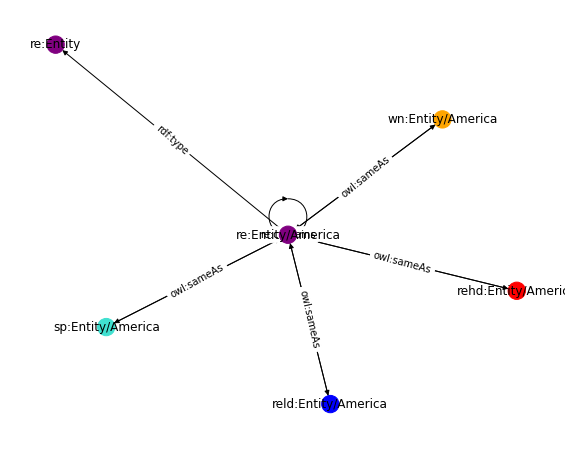

In [6]:
from relatio.triplestore import plot_graph

plot_graph(res)

## Miscellaneous

----------------------------

For a detailed discussion of semantic role annotations, please refer to: [Speech and Language Processing. Daniel Jurafsky & James H. Martin (2019)](https://web.stanford.edu/~jurafsky/slp3/old_oct19/20.pdf)

----------------------------

The package is still under development. We welcome comments, suggestions and bug reports:
[File an issue](https://github.com/relatio-nlp/relatio/issues)

----------------------------